In [2]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

DATA_DIR = os.path.join('.', 'results')

relative_error_avg :
	 20-71.csv : 23 0.0
	 36-157.csv : 183 0.0001047851903597
	 50-218.csv : 147 0.0140590357664909


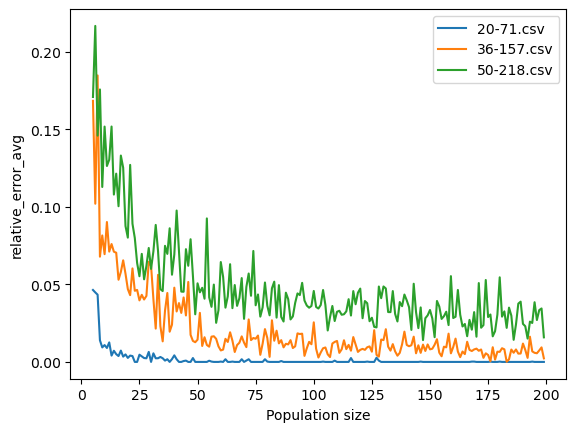

satisfied_clauses :
	 20-71.csv : 5 1.0
	 36-157.csv : 96 1.0
	 50-218.csv : 176 0.9967891


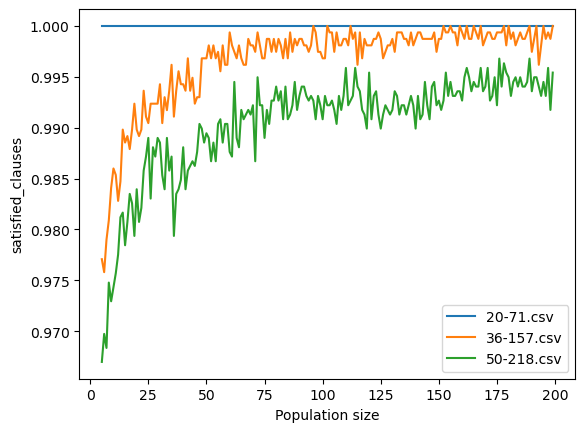

In [3]:
csv_files = glob.glob(os.path.join(DATA_DIR, '*.csv'))
basenames = [os.path.basename(file) for file in csv_files]
dfs = [pd.read_csv(file) for file in csv_files]

population_sizes = dfs[0]['population_size'].values

for column_name in ['relative_error_avg', 'satisfied_clauses']:
    print(column_name, ":")
    for i, df in enumerate(dfs):
        name = basenames[i].split('_')[0]
        plt.plot(population_sizes, df[column_name].values, label=name)


        if column_name == 'relative_error_avg':
            index = df[column_name].idxmin()
        else:
            index = df[column_name].idxmax()

        print('\t', name, ":", int(df.iloc[index]['population_size']), df.iloc[index][column_name])

    plt.xlabel('Population size')
    plt.ylabel(column_name)
    plt.legend()
    plt.show()    


## Finding optimal population size based on number of variables

$$p = a*V^b$$
$$log(p) = log(a*V^b)$$
$$log(p) = log(a) + b\cdot log(V)$$


In [4]:
COLUMN_NAME = 'relative_error_avg'
csv_files = glob.glob(os.path.join(DATA_DIR, '*.csv'))
basenames = [os.path.basename(file) for file in csv_files]
DFS = [pd.read_csv(file) for file in csv_files]

In [5]:
def get_problem_size(basename):
    numbers = basename.split('.')[0]
    variables, clauses = numbers.split('-')
    return int(variables)

def get_optimal_pop_size(x, y, threshold):
    dy_dx = np.gradient(y, x)
    elbow_indices = np.where(dy_dx < threshold)[0]
    if len(elbow_indices) > 0:
        return x[elbow_indices[0]]
    else:
        return np.median(y)

    return x[elbow_index]

### 1) Find optimal population size


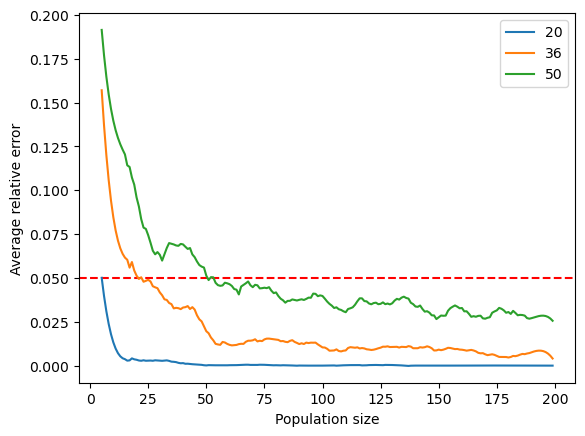

   problem_size  population_size
0            20                6
1            36               21
2            50               51


C:\Users\lukáš\AppData\Local\Temp\ipykernel_12716\1216403213.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  optimal_pop_df = optimal_pop_df.append({
C:\Users\lukáš\AppData\Local\Temp\ipykernel_12716\1216403213.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  optimal_pop_df = optimal_pop_df.append({
C:\Users\lukáš\AppData\Local\Temp\ipykernel_12716\1216403213.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  optimal_pop_df = optimal_pop_df.append({


In [13]:
optimal_pop_df = pd.DataFrame(columns=['problem_size', 'population_size'], dtype=int)

threshold = 0.05

# get data
data = {}
for df, name in zip(DFS, basenames):
    data[get_problem_size(name)] = {
        'x': df['population_size'].values,
        'y': df[COLUMN_NAME].values
    }

# smooth data
from scipy.signal import savgol_filter

# plot line with threshold
plt.axhline(y=threshold, color='r', linestyle='--')

for problem_size, d in data.items():
    # d['y'] = np.convolve(d['y'], np.ones(5) / 5, mode='same')
    d['y'] = savgol_filter(d['y'], 21, 3)
    plt.plot(d['x'], d['y'], label=problem_size)
plt.xlabel('Population size')
plt.ylabel('Average relative error')
plt.legend()
plt.show()

# get optimal population size
for problem_size, d in data.items():
    opt_population_size = d['x'][np.where(d['y'] < threshold)[0][0]]
    # opt_population_size = get_optimal_pop_size(d['x'], d['y'])

    optimal_pop_df = optimal_pop_df.append({
        'problem_size': problem_size,
        'population_size': opt_population_size
    }, ignore_index=True)

print(optimal_pop_df.head())

Now log-transform the data


In [14]:
optimal_pop_df['log_population_size'] = np.log(optimal_pop_df['population_size'])
optimal_pop_df['log_problem_size'] = np.log(optimal_pop_df['problem_size'])

print(optimal_pop_df.head())

   problem_size  population_size  log_population_size  log_problem_size
0            20                6             1.791759          2.995732
1            36               21             3.044522          3.583519
2            50               51             3.931826          3.912023


### 2.a Linear regression


Fitted power law model: y = 0.005736956741599898 * x^2.3115006068836115


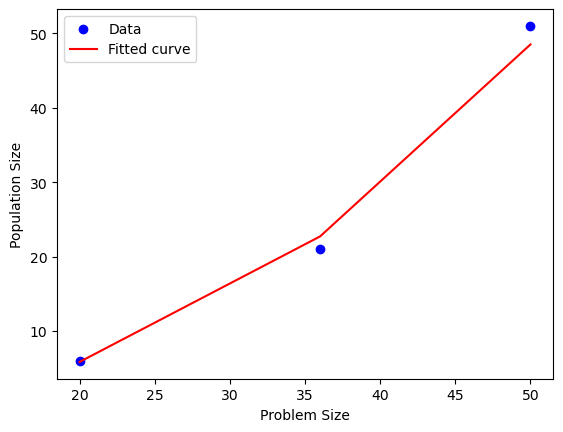

Problem size: 20, Optimal population size: 6, Fitted value: 5.834628374872979
Problem size: 36, Optimal population size: 21, Fitted value: 22.7026079915089
Problem size: 50, Optimal population size: 51, Fitted value: 48.51228949775377


In [15]:
from sklearn.linear_model import LinearRegression

log_X = optimal_pop_df['log_problem_size'].values.reshape(-1, 1)
log_y = optimal_pop_df['log_population_size'].values

model = LinearRegression()
model.fit(log_X, log_y)

# Get the coefficients (slope and intercept)
b = model.coef_[0]  # This is 'b' in the power law model
ln_a = model.intercept_  # This is 'ln(a)' in the power law model

# Back-transform to get a from ln(a)
a = np.exp(ln_a)

print(f'Fitted power law model: y = {a} * x^{b}')

# Plotting the original data and the fitted curve
x_vals = optimal_pop_df['problem_size']
y_vals = optimal_pop_df['population_size']

# Plot the data and the fitted power law curve
plt.scatter(x_vals, y_vals, label='Data', color='blue')
plt.plot(x_vals, a * (x_vals**b), color='red', label='Fitted curve')
plt.xlabel('Problem Size')
plt.ylabel('Population Size')
plt.legend()
plt.show()

for x, y in zip(x_vals, y_vals):
    optimal_value = a * x**b
    print(f'Problem size: {x}, Optimal population size: {y}, Fitted value: {optimal_value}')

In [21]:
 0.005737 * (100**2.3115)

240.81572911564115